In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import pickle
import json
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from icecream import ic
from import_casa import casa

In [3]:
import torch

In [4]:
data_dir = casa.get_data_path() / "eda/context"

In [5]:
context_v_path = casa.get_data_path() / "eda/context/context_v.xlsx"
context_v = pd.read_excel(context_v_path, sheet_name=0, index_col=None).iloc[1:, 1:8]

In [6]:
context_v.iloc[1, :]

annotator                                                 amy
context                                          中華、遠傳，蓋一座拆一座
rating                                                    1.0
V.+                                                 蓋/VC 拆/VC
sentiment_annotation                          蓋/VC.neu 拆/VC.n
sentiment_annotation_events    (cause) 蓋/VC.neu (main) 拆/VC.n
cues                                                      NaN
Name: 2, dtype: object

### Load from cached

In [13]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
label_enc.fit_transform(["cause", "conseq", "none"])

inst_path = casa.get_data_path()/"eda/context/event_rel_instances.pkl"
if inst_path.exists():
    with inst_path.open("rb") as fin:
        instances = pickle.load(fin)
        print(len(instances))

139


In [14]:
from collections import Counter
Counter([label_enc.classes_[x["label"]] for x in instances])

Counter({'cause': 50, 'none': 63, 'conseq': 26})

In [15]:
from sklearn.utils.class_weight import compute_class_weight
cls_weights = compute_class_weight("balanced", list(range(len(label_enc.classes_))), [x["label"] for x in instances])


In [16]:
label_enc.classes_, cls_weights

(array(['cause', 'conseq', 'none'], dtype='<U6'),
 array([0.92666667, 1.78205128, 0.73544974]))

## Ensemble model

In [23]:
from sklearn.svm import SVC
n_inst = len(instances)
Xh = np.zeros((n_inst, 768))
y = np.zeros(n_inst)
for inst_i, inst_x in enumerate(insts):
    hidden = inst_x["hidden_x"] + inst_x["hidden_y"]
    Xh[inst_i, :] = hidden.numpy()
    y[inst_i] = inst_x["label"]


In [38]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(Xh, y, train_size=120, stratify=y, random_state=1234)
np_rng = np.random.RandomState(12344)
cls_list = []
test_arr = []
for i in range(10):
    Xh_part, _, y_part, _ = train_test_split(trainX, trainY, train_size=100, stratify=trainY, random_state=np_rng)
    cls_ = SVC(kernel="linear")
    cls_.fit(Xh_part, y_part)
    print("train", cls_.score(Xh_part, y_part), "test", cls_.score(testX, testY))    
    test_arr.append(cls_.predict(testX))
    cls_list.append((f"cls_{i}", cls_))

train 0.88 test 0.3684210526315789
train 0.87 test 0.42105263157894735
train 0.86 test 0.3684210526315789
train 0.86 test 0.21052631578947367
train 0.88 test 0.42105263157894735
train 0.85 test 0.3684210526315789
train 0.9 test 0.3684210526315789
train 0.88 test 0.3157894736842105
train 0.9 test 0.3157894736842105
train 0.87 test 0.2631578947368421


In [50]:
np.vstack(test_arr).T.shape

(19, 10)

In [51]:
np.argmax([1,2,3])

2

In [52]:
test_mat = np.vstack(test_arr).T
test_pred = []
test_prob = []
for i in range(test_mat.shape[0]):
    prob = np.zeros(3)
    for k in range(3):
        prob[k] = (test_mat[i, :] == k).sum()/test_mat.shape[1]
    test_pred.append(prob.argmax())
    test_prob.append(prob.max())   

In [55]:
sum(np.equal(test_pred, testY)) / len(testY)

0.3157894736842105

In [36]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(Xh, y, train_size=120, stratify=y, random_state=1234)
np_rng = np.random.RandomState(12344)

cls_ = SVC(kernel="linear")
cls_.fit(trainX, trainY)
print("train", cls_.score(trainX, trainY), "test", cls_.score(testX, testY))    

train 0.8416666666666667 test 0.3684210526315789


In [56]:
cls_ = SVC(kernel="linear")
cls_.fit(Xh, y)
print("acc", cls_.score(Xh, y)) 

acc 0.8273381294964028


In [69]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
r_lda = LinearDiscriminantAnalysis()
lda.fit(Xh, y)
r_lda.fit(Rh, y)
lda.score(Xh, y), r_lda.score(Rh, y)

(0.8273381294964028, 0.5827338129496403)

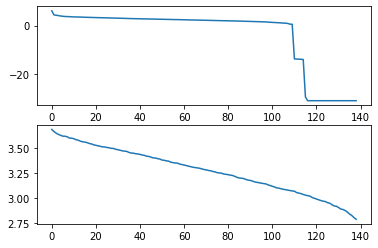

In [70]:
from matplotlib import pyplot as plt
plt.subplot(2, 1, 1)
plt.plot(np.log(np.linalg.svd(Xh)[1]))
plt.subplot(2, 1, 2)
plt.plot(np.log(np.linalg.svd(Rh)[1]))

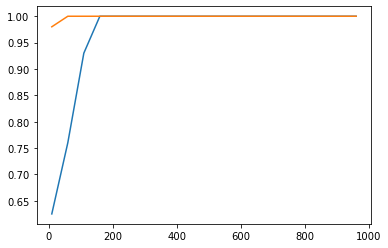

In [96]:
from sklearn.svm import SVC
accsR, accsZ = [], []
# Ry = np.random.randint(0, 2, size=100)
ks = range(10, 1010, 50)
N = 200
for k in tqdm(ks):
    z = np.random.randn(k)    
    Rh = np.random.randn(N, k)
    Zy = (np.dot(Rh, z)>0).astype(np.int32)
    Ry = np.random.randint(0, 2, size=N)
    
    # ldaR = LinearDiscriminantAnalysis()
    clsR = SVC(kernel="linear")
    clsR.fit(Rh, Ry)
    accsR.append(clsR.score(Rh, Ry))
    
    clsZ = SVC(kernel="linear")
    clsZ.fit(Rh, Zy)
    accsZ.append(clsZ.score(Rh, Zy))
plt.plot(ks, accsR, ks, accsZ)

array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0])

## Structure

In [40]:
label_list = ['B-VN', 'B-VP', 'I-VN', 'I-VP', 'O']

In [41]:
att_list = out.attentions

In [202]:
attz = att_list[-1][0][:, 1:-1, 1:-1]
attz.shape

torch.Size([12, 16, 16])

In [203]:
attz0 = attz[0]

In [204]:
import igraph as ig
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Microsoft JhengHei"
plt.rcParams["axes.unicode_minus"] = False

In [205]:
def plot_att_tree(att_mat, ax):    
    G = ig.Graph.Weighted_Adjacency((-att_mat).numpy().tolist(), mode=ig.ADJ_UNDIRECTED)
    mG = G.spanning_tree(weights=G.es["weight"])    

    deg = []
    for i in range(len(mG.vs)):
        deg.append(len(mG.neighbors(i, mode="all")))    

    # print tree relations
    root = np.argsort(deg)[-1]
    buf = [root]
    visited = set()
    emap = {}
    while buf:
        node = buf.pop()
        visited.add(node)
        children = mG.neighbors(node)    
        buf.extend(x for x in children if x not in visited)  
        emap.update({c: node for c in children})
    # for tok_i, tok_x in enumerate(toks):        
    #     print(tok_i, tok_x, toks[emap[tok_i]])
    
    layout=mG.layout_reingold_tilford(root=[root])
    ig.plot(mG, layout=layout, target=ax)
    coords = layout.coords
    for i in range(len(coords)):
        ax.text(coords[i][0], coords[i][1], toks[i], fontsize=12)

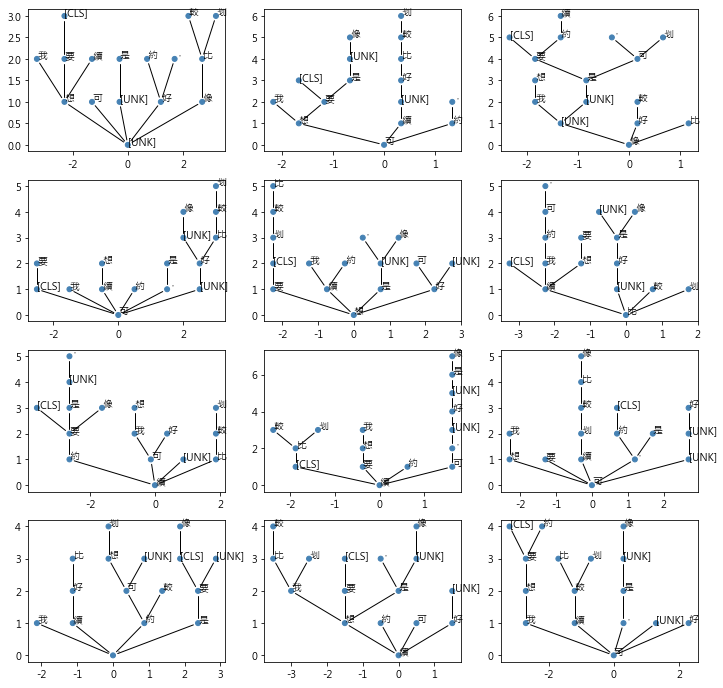

In [206]:
_, axes = plt.subplots(4, 3, figsize=(12,12))
for i in range(12):
    r = i // 3
    c = i % 3
    plot_att_tree(attz[i], axes[r][c])